In [1]:
from typing import *
from selectolax.parser import HTMLParser
from tqdm import tqdm


import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

<h4>School of Quants. Python project 3</h4>

<b>Mikhail Mironov</b>

<p>My strategy is based on trend continuation, best performers will likely remain top-performers for the next couple of weeks and worst will remain the worst. I long a portfolio maximizing Sharpe ratio over the best stocks.</p> 

<p>Max-Sharpe with best performers and Max-CVAR</p>


<h4>Data collection. Collecting tickers that are in SP500 and downloading their daily close prices</h4>

In [2]:
headers = {
    "Cookie": "_ga=GA1.1.650380062.1716305055; cf_clearance=pMd5CIWyGAjVUvImYB32DHAoQeu5u3khE24j9owdRys-1716305055-1.0.1.1-7cUIX.Dk.2OuOjN1epJI2HkFAVWkMsvbkmixYZ0cs9Mzc4g9zTC3VQwBej72Yip6DvbIEZtvsnDhKnIXwguiAg; _ga_MWXZ0FBF55=GS1.1.1716305055.1.1.1716305378.0.0.0",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.0.0.0 Safari/537.36"
}

resp = requests.get(
    "https://www.slickcharts.com/sp500", headers=headers
)

# Parse html from the response
dom = HTMLParser(resp.text)

tickers: List[str] = [
    td.text().strip() for td in dom.css("table > tbody > tr >td:nth-child(3)")
]

In [3]:
# Change BRK.B to BRK-B and remove all nonnense
tickers = [
    ticker for ticker in tickers if not ticker[0].isdigit()
]
tickers.remove("BRK.B")
tickers += ["BRK-B"]

In [4]:
# using yfinance download historical close daily data for each ticker from the list above
import yfinance as yf


def download_ticker(ticker: str) -> pd.DataFrame:
    ticker: yf.Ticker = yf.Ticker(ticker=ticker)
    df_ticker: pd.DataFrame = ticker.history(period="5y")
    return df_ticker


df: pd.DataFrame = pd.DataFrame()

for ticker in tqdm(tickers):
    df_ticker: pd.DataFrame = download_ticker(ticker=ticker)
    # Only leave close column and concat to the df
    df_close = df_ticker["Close"].to_frame()
    df_close = df_close.rename(columns={"Close": f"{ticker}_close"})
    
    df = pd.concat([df, df_close], axis=1)

 95%|█████████▌| 479/503 [01:18<00:03,  6.56it/s]SOLV: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', 'ytd', 'max']
$BF.B: possibly delisted; No price data found  (period=5y)
 96%|█████████▌| 482/503 [01:18<00:02,  8.25it/s]

$BF.B: possibly delisted; No price data found  (period=5y)


100%|██████████| 503/503 [01:21<00:00,  6.15it/s]


In [5]:
df = df.iloc[1:, :].copy()

In [6]:
df = df.dropna(axis=1)
df.head(1)

,MSFT_close,AAPL_close,NVDA_close,AMZN_close,GOOGL_close,META_close,GOOG_close,LLY_close,AVGO_close,JPM_close,...,NCLH_close,CMA_close,BEN_close,RL_close,MHK_close,BIO_close,PARA_close,FOX_close,NWS_close,BRK-B_close
Date,,,,,,,,,,,,,,,,,,,,,
2019-05-22 00:00:00-04:00,121.758331,44.100121,37.791584,92.984001,57.7925,185.123581,57.570999,109.667076,229.158218,95.582443,...,56.810001,57.509781,27.008337,101.527817,140.490005,295.350006,42.155834,33.998447,11.33006,202.600006


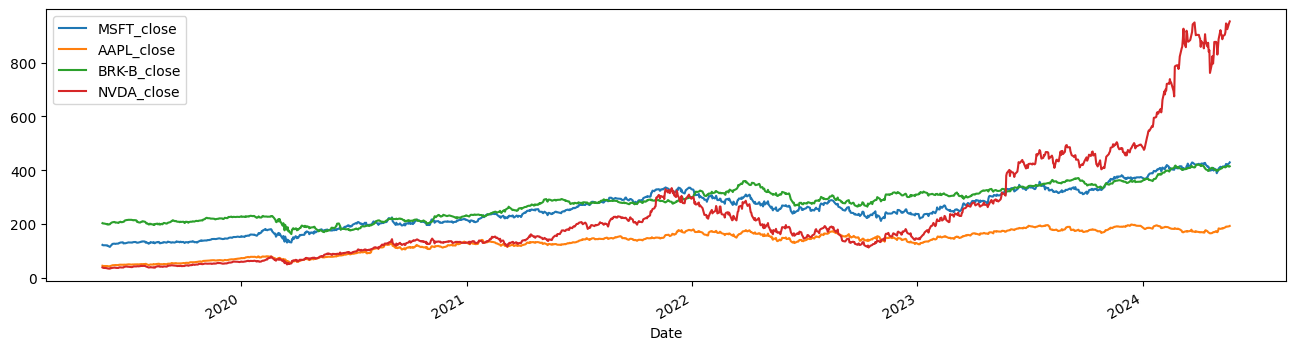

In [7]:
ticker_to_plot: List[str] = [
    "MSFT_close", "AAPL_close", "BRK-B_close", "NVDA_close"
]

df.plot(y=ticker_to_plot, figsize=(16, 4))
plt.show()

In [8]:
df.index = pd.to_datetime(df.index).tz_localize(None)
df.head(1)

,MSFT_close,AAPL_close,NVDA_close,AMZN_close,GOOGL_close,META_close,GOOG_close,LLY_close,AVGO_close,JPM_close,...,NCLH_close,CMA_close,BEN_close,RL_close,MHK_close,BIO_close,PARA_close,FOX_close,NWS_close,BRK-B_close
Date,,,,,,,,,,,,,,,,,,,,,
2019-05-22,121.758331,44.100121,37.791584,92.984001,57.7925,185.123581,57.570999,109.667076,229.158218,95.582443,...,56.810001,57.509781,27.008337,101.527817,140.490005,295.350006,42.155834,33.998447,11.33006,202.600006


In [9]:
df_returns = df.pct_change()
df_returns.columns = [col.split("_")[0]for col in df_returns.columns]
df_returns = df_returns.iloc[1:]

df_returns.head(1)

,MSFT,AAPL,NVDA,AMZN,GOOGL,META,GOOG,LLY,AVGO,JPM,...,NCLH,CMA,BEN,RL,MHK,BIO,PARA,FOX,NWS,BRK-B
Date,,,,,,,,,,,,,,,,,,,,,
2019-05-23,-0.011671,-0.01707,-0.032063,-0.023768,-0.009093,-0.024013,-0.009249,-0.009917,-0.033913,-0.019672,...,-0.022179,-0.024639,-0.013975,-0.031474,0.008684,-0.004706,-0.008485,-0.004363,0.000834,-0.006417


<h4>Strategy. Trend continuation. Best will continue outperforming others and the worst will keep falling</h4>

In [10]:
n_assets = df.shape[1]
n_assets

492

<h4>Max Sharpe optimization</h4>

In [11]:
from scipy.optimize import minimize


def max_sharpe_objective(W: np.array, df_train: pd.DataFrame) -> float:
    sigma_p = np.sqrt(W @ df_train.cov() @ W.T)
    R = df_train.mean(axis=0)
    return -np.dot(W, R) / sigma_p

def constr(W):
    return W.sum() - 1

constrs = [
    {"type": "eq", "fun": constr}
]

def find_optimial_portfolio(df_train: pd.DataFrame) -> np.array:
    n_assets: int = df_train.shape[1]
    
    x0 = [1 / n_assets] * n_assets

    res = minimize(
        fun=max_sharpe_objective,
        x0=x0,
        constraints=constrs,
        args=(df_train,)
    )
    return res.x

In [12]:
def test_portfolio(W: np.array, df_test: pd.DataFrame) -> float:
    final_returns = (1 + df_test).cumprod().iloc[-1]
    return np.dot(W, final_returns)

<h4>Train-backtest using a sliding window</h4>

In [13]:
train_size = 90
test_size = 14
TOP_K = 20

test_returns: List[float] = []
tp_dates: List[pd.Timestamp] = []


for i in tqdm(range(0, df_returns.shape[0] - train_size - test_size, test_size)):
    
    df_train = df_returns.iloc[i:(i+train_size)].copy()
    df_test = df_returns.iloc[(i+train_size):(i+train_size+test_size)].copy()

    # find best performing stocks on the train sample
    df_train_features = df_train.agg(["mean", "std", "median", "skew", "kurt", "max", "min"]).T
    df_train_features["cum_return"] = (df_train + 1).cumprod().iloc[-1]
    
    best_performers: List[str] = df_train_features.sort_values(by="cum_return", ascending=False).iloc[:TOP_K].index

    optimal_W: np.array = find_optimial_portfolio(
        df_train=df_train[best_performers]
    )

    test_return: float = test_portfolio(W=optimal_W, df_test=df_test[best_performers])
    
    tp_dates.append(df_test.index[-1])
    test_returns.append(test_return)

100%|██████████| 83/83 [00:25<00:00,  3.21it/s]


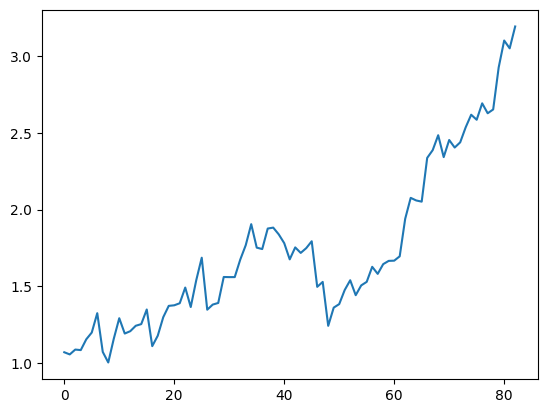

In [14]:
test_returns = np.array(test_returns)

plt.plot(test_returns.cumprod())
plt.show()

<h4>Compare to SP500 cumprod returns over the same timeperiod</h4>

In [15]:
df_sp500: pd.DataFrame = yf.Ticker(ticker="^GSPC").history(period="5y")
df_sp500.index = df_sp500.index.tz_localize(None)

df_sp500["cum_return"] = (df_sp500["Close"].pct_change() + 1).cumprod()
df_sp500.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,cum_return
Date,,,,,,,,
2019-05-22,2856.060059,2865.469971,2851.110107,2856.270020,3194000000,0.0,0.0,NaN
2019-05-23,2836.699951,2836.699951,2805.489990,2822.239990,3899320000,0.0,0.0,0.988086
2019-05-24,2832.409912,2841.360107,2820.189941,2826.060059,2889230000,0.0,0.0,0.989423
2019-05-28,2830.030029,2840.510010,2801.580078,2802.389893,4146980000,0.0,0.0,0.981136
2019-05-29,2790.250000,2792.030029,2766.060059,2783.020020,3701110000,0.0,0.0,0.974355


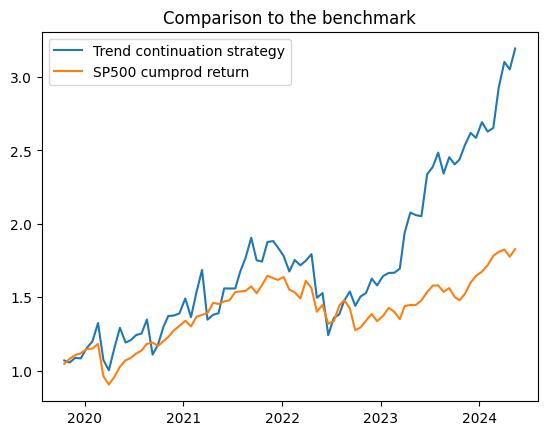

In [16]:
plt.title("Comparison to the benchmark")

plt.plot(tp_dates, test_returns.cumprod(), label="Trend continuation strategy")
plt.plot(tp_dates, df_sp500[df_sp500.index.isin(tp_dates)]["cum_return"], label="SP500 cumprod return")
plt.legend()
plt.show()

<h4>Clean up + flexibility</h4>

In [17]:
from abc import ABC, abstractmethod


class PortfolioFinder(ABC):
    """Cand define any objective but it must implement find_portfolio method"""

    def __init__(self) -> Self:
        super().__init__()

    @abstractmethod
    def find_portfolio(self, df_returns: pd.DataFrame) -> np.array:
        """Finds optimal portfolio"""


class MaxSharpeOptimizer(PortfolioFinder):

    def __init__(self) -> Self:
        super().__init__()

    def max_sharpe_objective(self, W: np.array, df_returns: pd.DataFrame) -> float:
        sigma_p = np.sqrt(W @ df_returns.cov() @ W.T)
        R = df_returns.mean(axis=0)
        return -np.dot(W, R) / sigma_p

    def constr(W):
        return W.sum() - 1
    
    def find_portfolio(self, df_returns: pd.DataFrame) -> np.array:
        """Optimize for MaxSharpe ratio"""
        constrs = [{"type": "eq", "fun": constr}]
        n_assets: int = df_returns.shape[1]
        x0 = [1 / n_assets] * n_assets
        
        res = minimize(
            fun=self.max_sharpe_objective,
            x0=x0,
            constraints=constrs,
            args=(df_returns,)
        )
        return res.x

In [18]:
class Trainer:
    """Trend continuation based strategy"""
    
    def __init__(self, df_returns: pd.DataFrame, optimizer: PortfolioFinder, df_sp500: pd.DataFrame) -> Self:
        self.df_returns: pd.DataFrame = df_returns
        self.optimizer: PortfolioFinder = optimizer
        self.test_log: List[Dict[str, Any]] = []

        self.df_sp500: pd.DataFrame = df_sp500


    def backtest(self, df_test: pd.DataFrame, W_star: np.array) -> None:
        asset_returns: np.array = (1 + df_test).cumprod().iloc[-1].values # get asset cumulative returns on the last day

        portfolio_return: float = np.dot(W_star, asset_returns)
        portfolio_max_daily_drawdown: float = ((1 + df_test) @ W_star).min() # find the worst daily return in df_test
        hh_index: float = np.sum(W_star**2)

        self.test_log.append({
            "portfolio_return": portfolio_return,
            "portfolio_max_daily_drawdown": portfolio_max_daily_drawdown,
            "hh_index": hh_index,
            "portfolio_weights": W_star,
            "time": df_test.index[-1]
        })

    def train(self, train_size: int, test_size: int, use_top_k: int, clean_log: bool = True):
        """Perform sliding window optimization and backtest of the strategy"""
        if clean_log:
            self.test_log = []

        for i in tqdm(
            range(0, self.df_returns.shape[0] - train_size - test_size, test_size)
        ):
            
            df_train = self.df_returns.iloc[i:(i+train_size)].copy()
            df_test = self.df_returns.iloc[(i+train_size):(i+train_size+test_size)].copy()

            # find best performing stocks on the train sample
            df_train_features = df_train.agg(["mean", "std", "median", "skew", "kurt", "max", "min"]).T
            df_train_features["cum_return"] = (df_train + 1).cumprod().iloc[-1]
            
            # Select the best performers
            best_performers: List[str] = df_train_features.sort_values(by="cum_return", ascending=False).iloc[:use_top_k].index
            
            W_star: np.array = self.optimizer.find_portfolio(df_returns=df_train[best_performers])
            self.backtest(df_test=df_test[best_performers], W_star=W_star)


    def plot_results(self) -> None:
        """Get data from test_log and display main metrics"""
        df_test = pd.DataFrame(self.test_log)
        df_test["cumprod_return"] = df_test["portfolio_return"].cumprod()

        fig, axs = plt.subplots(1, 3, figsize=(20, 5))
        ax1, ax2, ax3 = axs

        sp500_returns = df_sp500[df_sp500.index.isin(df_test["time"])]["cum_return"]

        df_test.plot(x="time", y="cumprod_return", ax=ax1, title="Cumulative return", label="Continuation strategy")
        ax1.plot(df_test["time"], sp500_returns, label="SP500 cumprod return")
        ax1.legend()

        df_test.plot(x="time", y="portfolio_max_daily_drawdown", ax=ax2, title="Max daily drawdown")
        df_test.plot(x="time", y="hh_index", ax=ax3, title="HH_index")

        plt.show()

<h4>Using TOP-10 assets</h4>

In [19]:
optimizer: PortfolioFinder = MaxSharpeOptimizer()
trainer = Trainer(
    df_returns=df_returns, optimizer=optimizer, df_sp500=df_sp500
)
trainer.train(train_size=90, test_size=14, use_top_k=10)

100%|██████████| 83/83 [00:21<00:00,  3.94it/s]


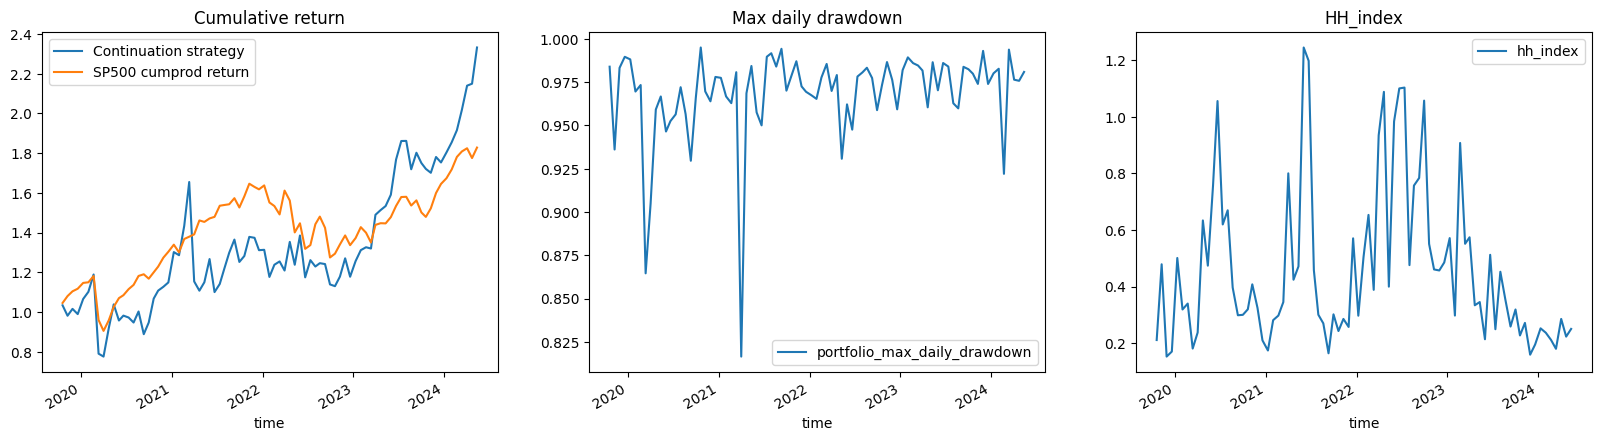

In [20]:
trainer.plot_results()

<h4>Using TOP-20 assets</h4>

100%|██████████| 83/83 [00:25<00:00,  3.20it/s]


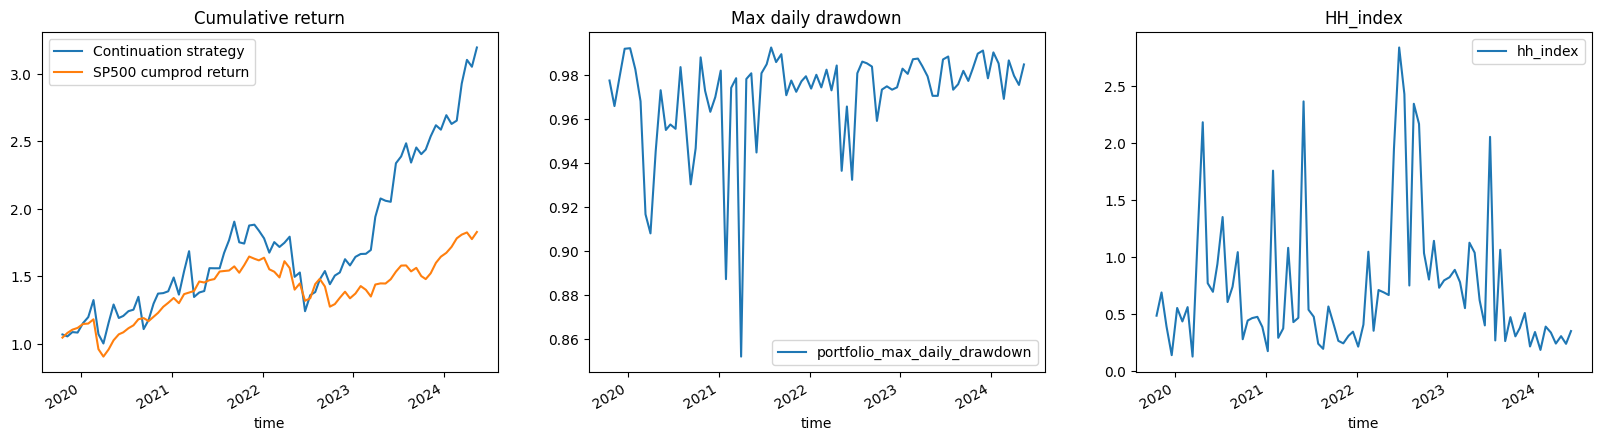

In [21]:
trainer.train(train_size=90, test_size=14, use_top_k=20, clean_log=True)
trainer.plot_results()

<h4>Using TOP-40 assets</h4>

100%|██████████| 83/83 [00:44<00:00,  1.87it/s]


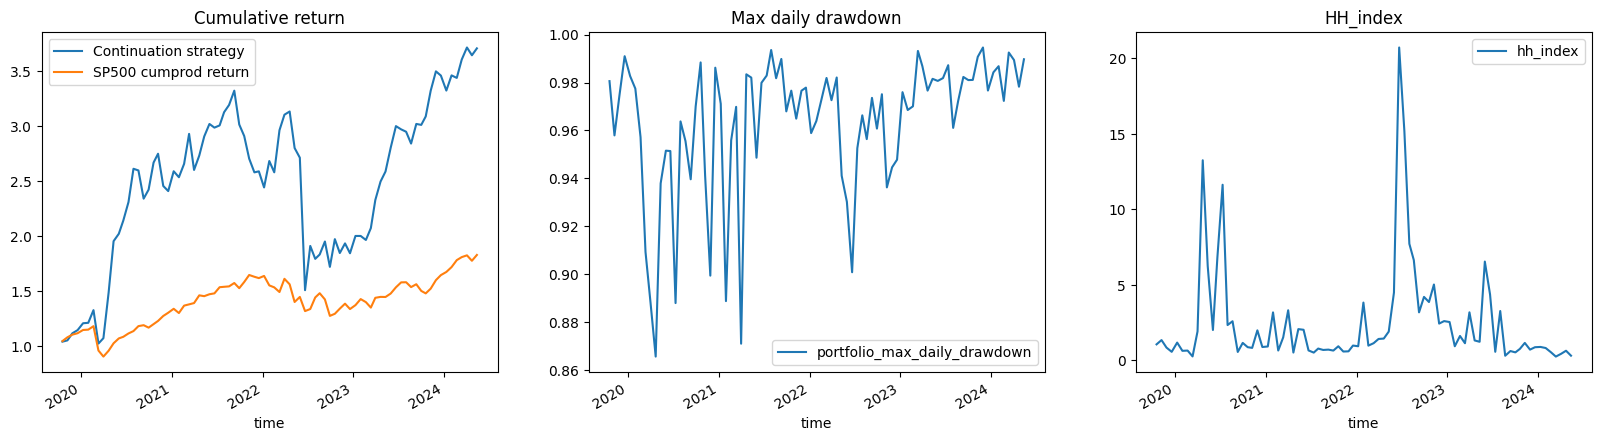

In [22]:
trainer.train(train_size=90, test_size=14, use_top_k=40, clean_log=True)
trainer.plot_results()

<h4>Varying train/test sample size</h4>

100%|██████████| 122/122 [00:51<00:00,  2.38it/s]


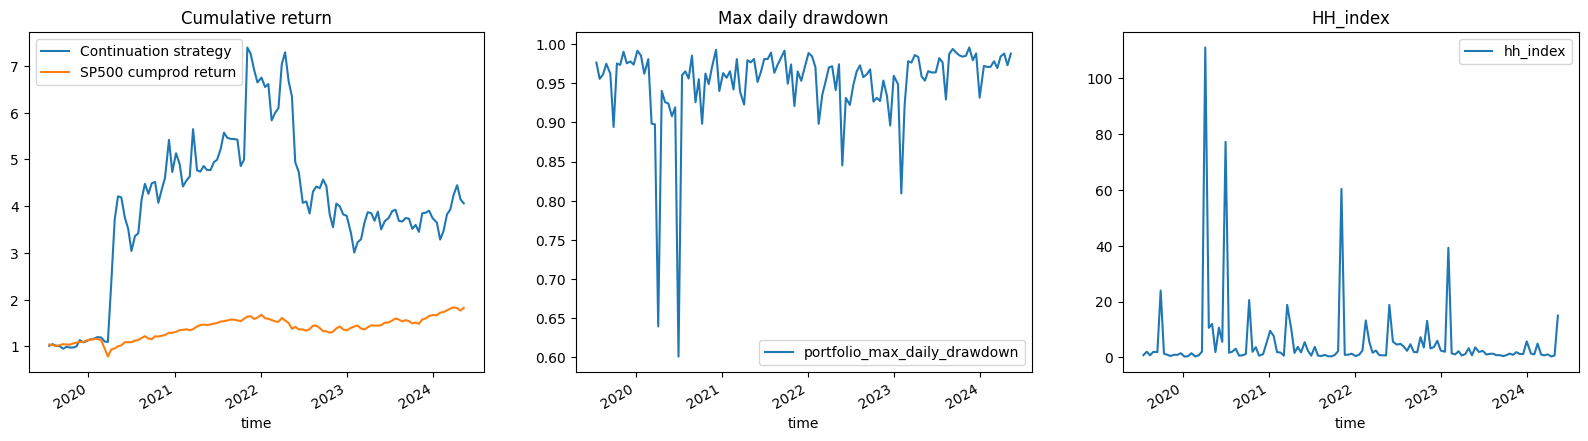

In [24]:
trainer.train(train_size=30, test_size=10, use_top_k=20, clean_log=True)
trainer.plot_results()

In [32]:
portfolio_returns: pd.Series = pd.DataFrame(trainer.test_log)["portfolio_return"]
# Sharpe ratio
portfolio_returns.mean() / portfolio_returns.std()

7.1561394225808055

<h4>Where ML &#128544</h4>

<p>Whatever I tried I saw nothing better that a coinflip 50-50, this is understandable given that we deal with financial data most of which is generated by unit root processes. I think ML could be used when there is actually something to detect, like manipulation in pumps and dumps in cryptocurrency markets (my current project), there I see how one can use ML/DL for classification and therefore use the logits for some sort of portfolio weights. We could have trained a model prediciting returns in 14 days, but I bet it would have been total garbage.</p>

<h4>CVAR target</h4>

In [33]:
class CVarMaximizer(PortfolioFinder):

    def __init__(self, quantile: float) -> Self:
        super().__init__()
        self.quantile = quantile

    @staticmethod
    def cvar_objective(W: np.array, df_returns: pd.DataFrame, quantile: float) -> float:
        """Maximize expected shortfall - mean of return distribution truncated at lower quantile distribution"""
        portfolio_return = df_returns @ W
        cvar: float = portfolio_return[portfolio_return < portfolio_return.quantile(quantile)].mean()
        return -cvar

    def constr(W):
        return W.sum() - 1
    
    def find_portfolio(self, df_returns: pd.DataFrame) -> np.array:
        """Optimize for MaxSharpe ratio"""
        constrs = [{"type": "eq", "fun": constr}]
        n_assets: int = df_returns.shape[1]
        x0 = [1 / n_assets] * n_assets
        
        res = minimize(
            fun=self.cvar_objective,
            x0=x0,
            constraints=constrs,
            args=(df_returns, self.quantile,)
        )
        return res.x
    

optimizer: PortfolioFinder = CVarMaximizer(quantile=.05)
trainer = Trainer(
    df_returns=df_returns, optimizer=optimizer, df_sp500=df_sp500
)
trainer.train(train_size=30, test_size=10, use_top_k=10)

100%|██████████| 122/122 [00:36<00:00,  3.34it/s]


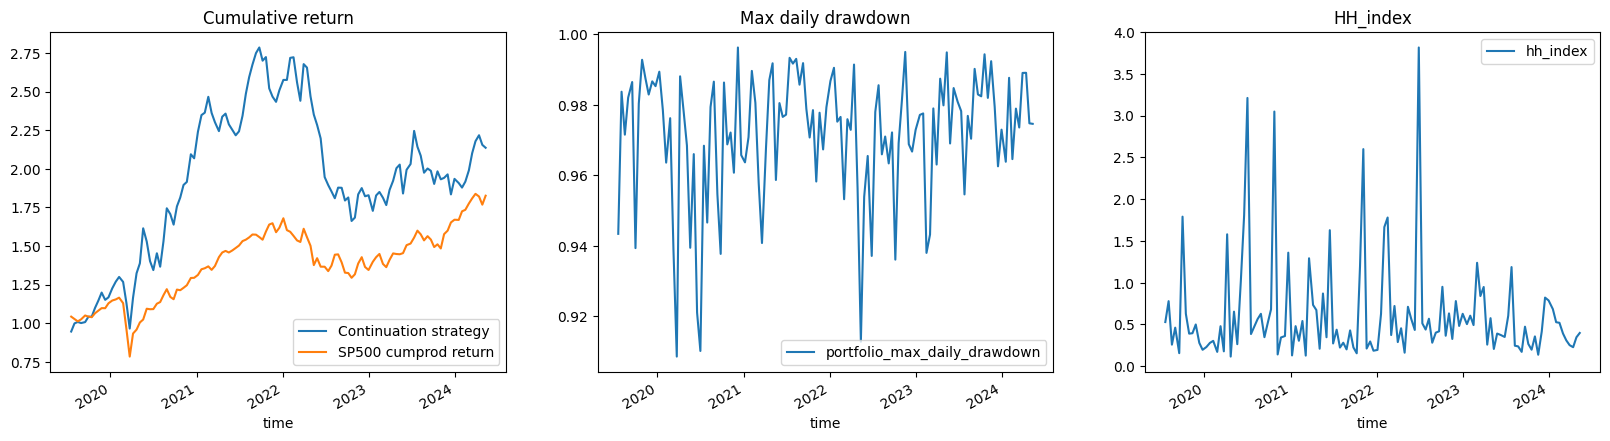

In [34]:
trainer.plot_results()

<p>We can also mix objectives to solve for multiple criteria</p>

<h4>Conclusions</h4>

Overall I believe we did great, I hope so. It is 6AM so everything could have gone wrong. 